## Using the em/feat/muinversion branch of SimPEG (http://github.com/simpeg/simpeg)

In [1]:
from CasingSimulations import * 
%matplotlib inline

In [2]:
directory = 'VariableMu1kmCasing'
cpfile = "CasingProperties.json"
resultsfile = "MagneticPermeabilityImpacts.hdf5"
rerun = False

# Model Parameters

In [3]:
# Save or load Results
cp_file = '{directory}/{cpfile}'.format(directory=directory, cpfile=cpfile)

if rerun is True:   
    cp = CasingProperties(freqs=[1e-1, 0.5, 1, 2, 5])
else:   
    with open(cp_file, 'r') as outfile:   
        cp = CasingProperties.deserialize(json.load(outfile))

In [4]:
CMesh = CasingMesh(cp)
CMesh.npadx2 = CMesh.npadx2 - 3
CMesh.npadzu = CMesh.npadzu - 3
CMesh.npadzd = CMesh.npadzd - 3
mesh = CMesh.mesh

In [5]:
print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(cp.sigmaback*f) for f in cp.freqs])
print([500./np.sqrt(cp.sigmacasing*f) for f in cp.freqs])

Cyl Mesh Extent xmax: 208853.54563,: zmin: -183013.550756, zmax: 182014.050756
2389520
[15811.388300841898, 7071.0678118654751, 5000.0, 3535.5339059327375, 2236.0679774997898]
[0.67419986246324204, 0.30151134457776363, 0.21320071635561044, 0.15075567228888181, 0.095346258924559224]


# plot model

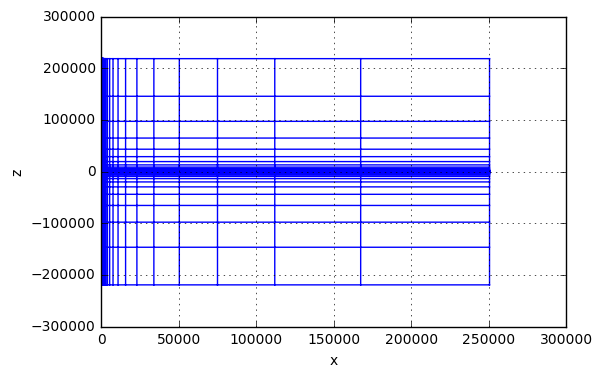

In [6]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

# fig.savefig('{}/{}'.format(directory, 'CylMesh.png'))

In [7]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(cp.sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

In [8]:
muModelInd = 1

sigma_m = np.r_[
    np.log(cp.sigmaback), np.log(cp.sigmalayer), np.log(cp.sigmacasing), np.log(cp.sigmainside),
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, cp.muModels[muModelInd]*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

In [9]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 23.7 s, sys: 636 ms, total: 24.4 s
Wall time: 25.5 s


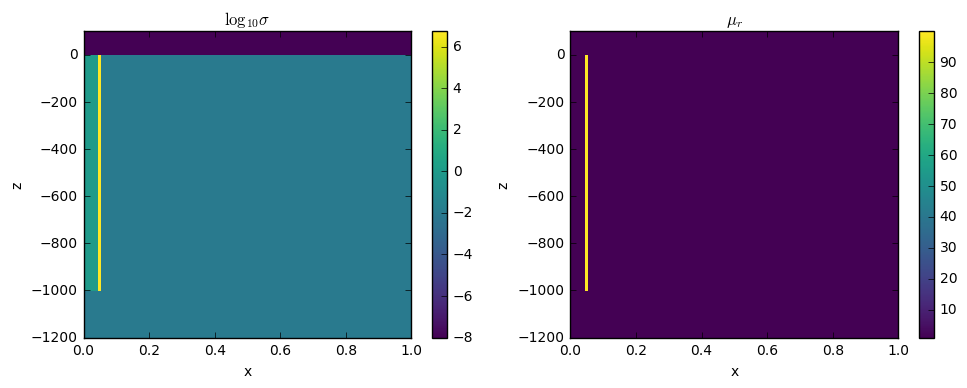

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = plotModels(mesh, sigma, mu, xlim=[0.,1.], zlim=[-1200., 100.], ax=ax)
# fig.savefig('{}/{}'.format(directory, 'PhysPropModels'))

# Set up the Source

In [11]:
# down-holeSource
dhSrc = DownHoleCasingSrc(mesh, cp.src_a, cp.src_b, cp.casing_a, cp.freqs)

th_src_a = np.r_[0., 0., 0.]
thSrc = TopCasingSource(mesh, th_src_a, cp.src_b, cp.casing_a, cp.freqs)

(-951.0, -949.0)

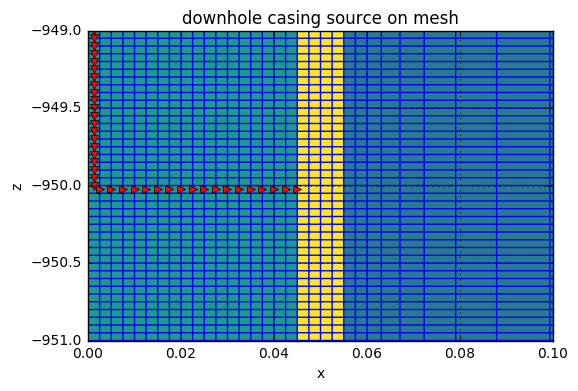

In [12]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
dhSrc.plotSrc(ax=ax)

ax.set_title('downhole casing source on mesh')

ax.set_xlim([0, 0.1])
ax.set_ylim([-951., -949.])

# fig.savefig('{}/{}'.format(directory, 'SourceOnMesh.png'))

# Problem and Survey

In [13]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=Maps.IdentityMap(mesh))
survey = FDEM.Survey(dhSrc.s_e + thSrc.s_e)
prob.solver = Solver
prob.pair(survey)

In [14]:
muCasing = 50. 
anomMu_z = np.r_[-900., -850.]

In [15]:
permeabilityModel = muMap * np.r_[
    mu_0, mu_0, muCasing*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

anomChunk = (
    (mesh.gridCC[:, 0] <= cp.casing_b) & 
    (mesh.gridCC[:, 0] >= cp.casing_a) &
    (mesh.gridCC[:, 2] >= anomMu_z[0]) &
    (mesh.gridCC[:, 2] <= anomMu_z[1])
)

def MuCasingModel(mucasing):
    mod = permeabilityModel.copy()
    mod[anomChunk] = mucasing*mu_0
    return mod

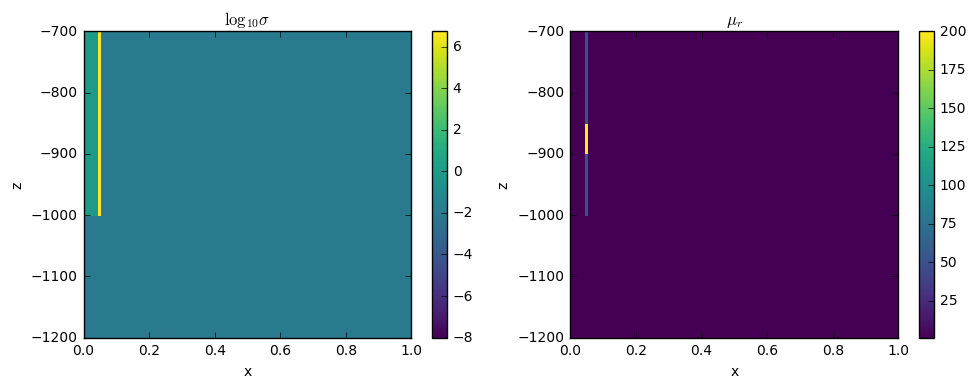

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = plotModels(mesh, sigma, MuCasingModel(200.), xlim=[0.,1.], zlim=[-1200., -700.], ax=ax)

In [17]:
cp.muModels = [50., 100., 200.]
fields = {}

In [18]:
if rerun is True:
    # create a file to store results
    results = h5py.File("{}/{}".format(directory, resultsfile), "w")
else:
    results = h5py.File("{}/{}".format(directory, resultsfile), "r")

In [19]:
results.keys()

[u'fields_100', u'fields_200', u'fields_50']

In [20]:
%%time
for muMod in cp.muModels:
    tag = int(muMod)
    curMu = MuCasingModel(muMod)

    if rerun is True:
        print('solving mu = {}mu_0'.format(tag))
        fields[tag] = prob.fields(curMu)
        dbentry = "fields_{tag}".format(tag=tag)
        results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
        print('... saved fields_{tag}'.format(tag=tag))
        
        # Save parameters used to produce these fields
        with open(cp_file, 'w') as outfile:
            json.dump(cp.serialize(), outfile)

    else:
        print('loading mu = {}mu_0'.format(tag))
        prob.model = curMu
        f = prob.fieldsPair(mesh, survey)
        f[:, 'hSolution'] = results['fields_{}'.format(tag)].value
        fields[tag] = f
        print('... loaded mu = {}mu_0'.format(tag))

loading mu = 50mu_0
... loaded mu = 50mu_0
loading mu = 100mu_0
... loaded mu = 100mu_0
loading mu = 200mu_0
... loaded mu = 200mu_0
CPU times: user 7.22 s, sys: 4.76 s, total: 12 s
Wall time: 14.5 s


0.1 Hz, 50.0 mu_0


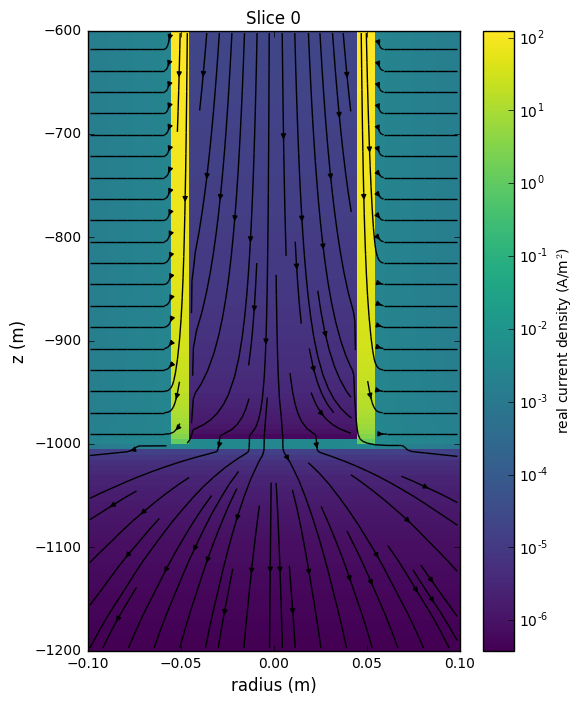

In [21]:
# def vecplot_j(muind, freqind, reim='real'):
    
#     src = survey.getSrcByFreq(survey.freqs[freqind])[0]
#     mur = cp.muModels[muind]
        
#     print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))
#     ax = plotCurrentDensity(
#         mesh, fields[mur][src, 'j'], csx=0.01, csz=5., 
#         xmax=0.2, zmin=-600., zmax=-1100., real_or_imag=reim
#     )
#     return ax

# w = widgets.interactive(
#         vecplot_j, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1, continuous_update=False),
#         freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1, continuous_update=False),
#         reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False)
# )
# w
# #ax.axis('equal', adjustable='box')

def vecplot_j(muind, freqind, reim='real', th_bh = 'bh'):
    fig, ax = plt.subplots(1,1, figsize=(6,8))
    src = survey.getSrcByFreq(survey.freqs[freqind])
    src = src[0] if th_bh == 'bh' else src[1]
    mur = cp.muModels[muind]
    
    print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))
    ax1 = plotCurrentDensity(
        mesh, fields[mur][src, 'j'], csx=0.0025, csz=5., 
        xmax=0.1, zmin=-600., zmax=-1200., real_or_imag=reim, mirror=True, ax=ax, fig=fig, saveFig=False
    )
    return ax1

w = widgets.interactive(
        vecplot_j, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1, continuousUpdate=False),
        freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1, continuousUpdate=False),
        reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False), 
        th_bh=widgets.ToggleButtons(options=['th', 'bh'], continuousUpdate=False)
)
w
#ax.axis('equal', adjustable='box')

In [22]:
%%time 

IxCasing, IzCasing = CasingCurrents(cp, fields, mesh, survey)

CPU times: user 11 s, sys: 10.4 s, total: 21.3 s
Wall time: 28.7 s


mu = 50.0 mu_0


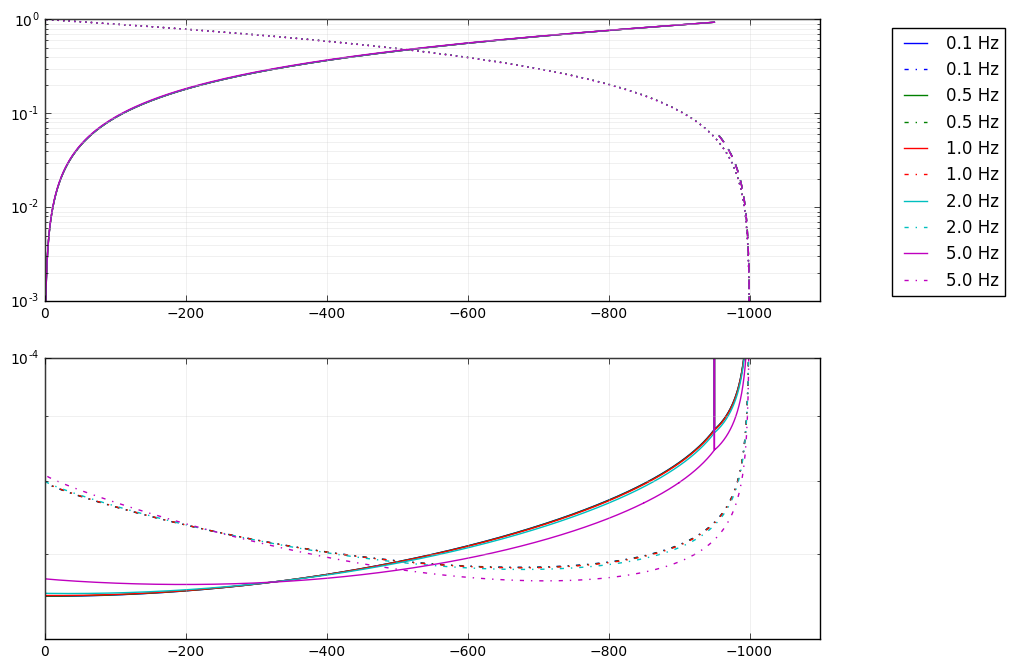

In [26]:
# def plotMe_freq(muopt, reim, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
#     mur = cp.muModels[muopt]
#     ax = plot_currents_over_freq(
#         IxCasing, IzCasing, cp, mesh, mur, subtract=subtract, real_or_imag=reim, 
#         ax=ax
#     )  
    

# w = widgets.interact(
#     plotMe_freq, 
#     muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1), 
#     reim=widgets.ToggleButtons(options=['real', 'imag']),
#     subtract=widgets.ToggleButtons(options=[None, 1])
# )
def plotMe_freq(
    muopt, reim, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4, savefig=True
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = cp.muModels[muopt]
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
    
    plot_currents_over_freq(
        IxCasing, IzCasing, cp, mesh, mur, subtract=subtract, real_or_imag=reim, 
        ax=ax, logScale=logScale, srcinds=srcinds, ylim_0=ylim_0, ylim_1=ylim_1
    )  
    plt.show()
    
    if savefig:
        fig.savefig('casingCurrents', dpi=300)

w = widgets.interact(
    plotMe_freq, 
    muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1, continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False), 
    ylim_0l=widgets.FloatText(1e-3, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1, continuousUpdate=False),
    ylim_1l=widgets.FloatText(6e-5, continuousUpdate=False),
    ylim_1u=widgets.FloatText(1e-4, continuousUpdate=False),
)


0.1 Hz


<function __main__.plotMe_mu>

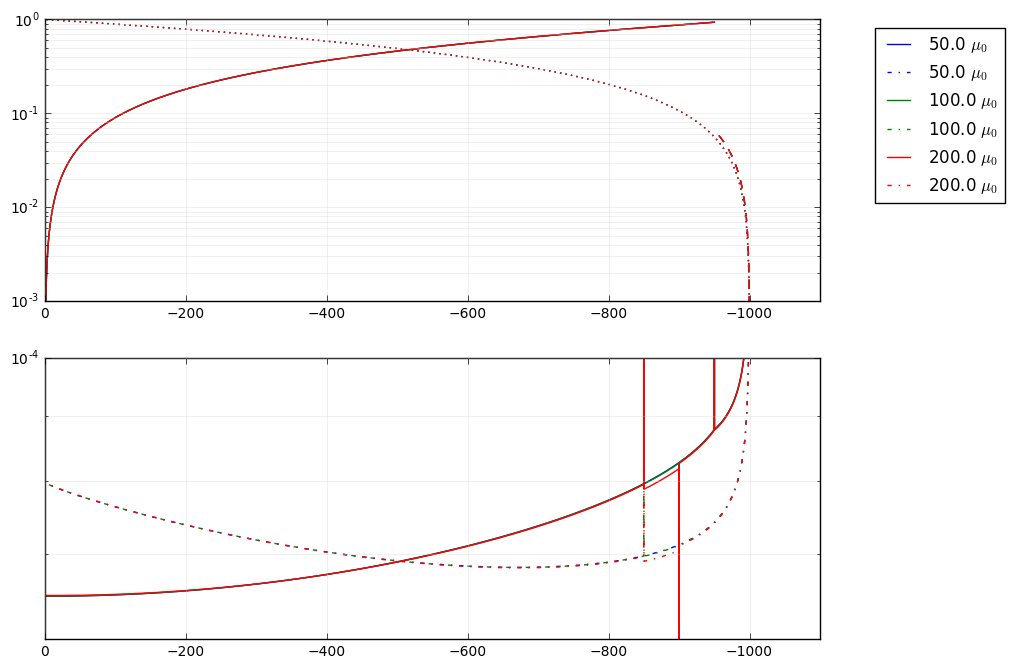

In [24]:
# def plotMe_mu(freqopt, reim, subtract=None):
# #     fig, ax = plt.subplots(2,1, figsize=(10,8))
#     freq = cp.freqs[freqopt]
#     plot_currents_over_mu(IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim)  

# w = widgets.interact(
#     plotMe_mu, 
#     freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
#     reim=widgets.ToggleButtons(options=['real', 'imag']),
#     subtract=widgets.ToggleButtons(options=[None, 1])
# )

# w

def plotMe_mu(
    freqopt, reim, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
    plot_currents_over_mu(
        IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim,
        logScale=logScale, srcinds=srcinds, ylim_0=ylim_0, ylim_1=ylim_1
    )  

w = widgets.interact(
    plotMe_mu, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False),
    subtract=widgets.ToggleButtons(options=[None, 1], continuousUpdate=False),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-3, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1, continuousUpdate=False),
    ylim_1l=widgets.FloatText(6e-5, continuousUpdate=False),
    ylim_1u=widgets.FloatText(1e-4, continuousUpdate=False)
)

w

5.0 Hz


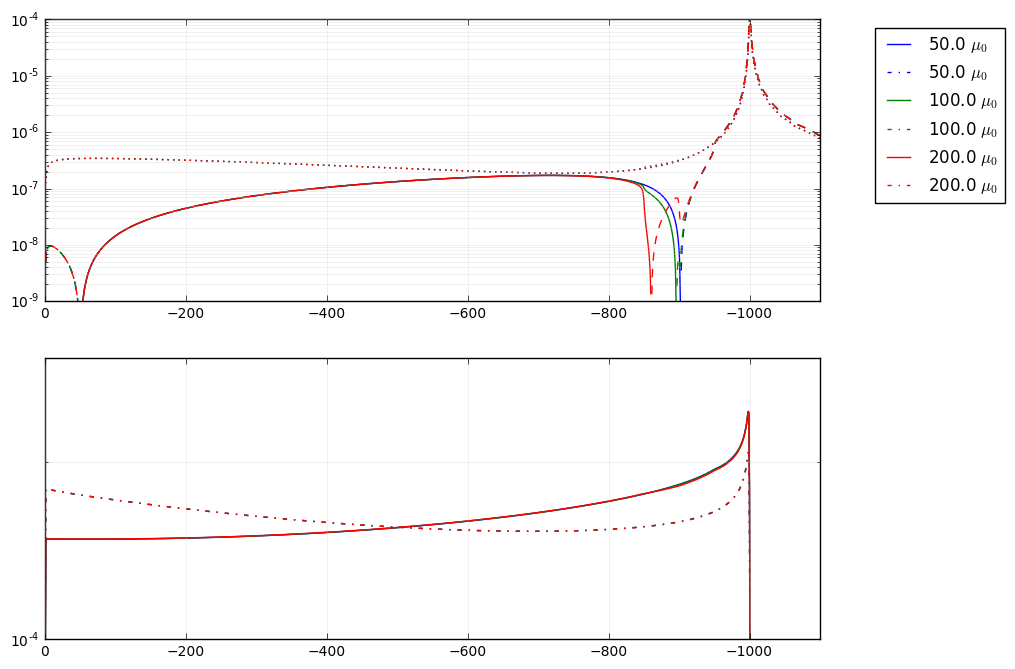

In [25]:
# def plotMe_j_mu_z(freqopt, reim, r, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
#     freq = cp.freqs[freqopt]
#     plot_j_over_mu_z(
#         cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, 
#         real_or_imag=reim, ax=ax
#     )  
# #     ax[1].set_ylim([9e-5, 3e-4])

# widgets.interact(
#     plotMe_j_mu_z, 
#     freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
#     r=widgets.FloatText(value=1., continuousUpdate=False), 
#     reim=widgets.ToggleButtons(options=['real', 'imag']),
#     subtract=widgets.ToggleButtons(options=[None, 1])
# )

def plotMe_j_mu_z(
    freqopt, reim, r, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_mu_z(
        cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, srcinds=srcinds,
        real_or_imag=reim, ax=ax, ylim_0 = ylim_0, ylim_1 = ylim_1, logScale=logScale
    )  
#     ax[1].set_ylim([1e-4, 3e-4])

widgets.interact(
    plotMe_j_mu_z, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    r=widgets.FloatText(value=1., continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-9, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1l=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1u=widgets.FloatText(3e-4, continuousUpdate=False)
)

0.1 Hz


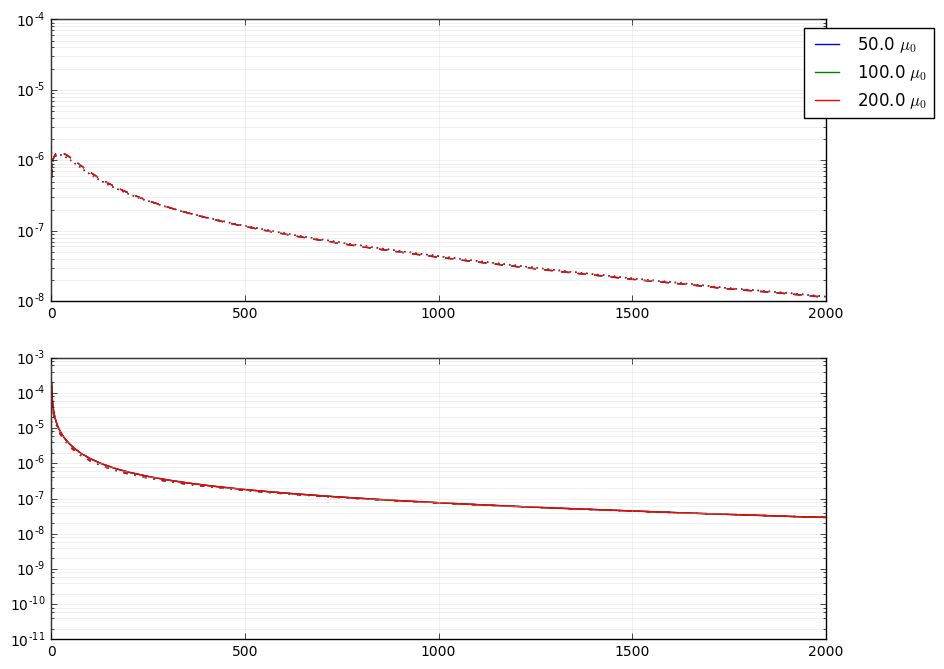

In [41]:
# def plotMe_j_mu_x(freqopt, reim, z, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
#     freq = cp.freqs[freqopt]
#     plot_j_over_mu_x(cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax)
#     plt.show()

# j_over_x = widgets.interactive(
#     plotMe_j_mu_x, 
#     freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
#     z=widgets.FloatText(value=-950., continuous_update=False), 
#     subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
#     reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False)
# )
# j_over_x

def plotMe_j_mu_x(
    freqopt, reim, z, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = None #[ylim_0l, ylim_0u]
    ylim_1 = None #[ylim_1l, ylim_1u]
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_mu_x(
        cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax,
        srcinds=srcinds, logScale=logScale, ylim_0=ylim_0, ylim_1=ylim_1
    )
    plt.show()

j_over_x = widgets.interactive(
    plotMe_j_mu_x, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
    z=widgets.FloatText(value=-950., continuous_update=False), 
    subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False]),
    ylim_0l=widgets.FloatText(1e-9),
    ylim_0u=widgets.FloatText(1e-4),
    ylim_1l=widgets.FloatText(1e-4),
    ylim_1u=widgets.FloatText(3e-4)
)
j_over_x